# Import de librerías necesarias

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, SimpleRNN
from tensorflow import keras
import math
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
#Esta celda es por problemas de compatibilidad con la GPU en la última actualización

from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

# Lectura de la base de datos de MEData

In [3]:
df = pd.read_csv('Dataset/hurto_a_persona.csv', sep=';')

e:\ProgramasInstalados\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (25) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


En vista de que pueden haber entradas duplicadas se procede a eliminarlas

In [4]:
df.drop_duplicates(inplace=True)

Se eliminan las edades que se salgan del rango entre 0 y 100

In [5]:
filt = df[df['edad'] <= 0]
df.drop(filt.index, inplace=True)
filt = df[df['edad'] > 100]
df.drop(filt.index, inplace=True)

In [6]:
df.shape

(246844, 36)

# Enfoque en el barrio El Poblado

Se va a enfocar este trabajo en el barrio "El Poblado", por lo que se crea un nuevo dataframe con únicamente la información de este barrio

In [7]:
filt = df[df['nombre_barrio']=='El Poblado']
dfP = filt.copy()

In [8]:
dfP.head(2)

,fecha_hecho,cantidad,latitud,longitud,sexo,edad,estado_civil,grupo_actor,actividad_delictiva,parentesco,...,lugar,sede_receptora,bien,categoria_bien,grupo_bien,modelo,color,permiso,unidad_medida,fecha_ingestion
279,2018-03-25T04:00:00.000-05:00,1.0,620.902.199,-7.556.798.437,Mujer,23,Soltero(a),Sin dato,Sin dato,Sin dato,...,Vía pública,Poblado,Tarjeta bancaria,"Dinero, joyas, piedras preciosas y título valor",Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00
281,2018-03-25T04:00:00.000-05:00,1.0,620.902.199,-7.556.798.437,Mujer,23,Soltero(a),Sin dato,Sin dato,Sin dato,...,Vía pública,Poblado,Licencia,Documentos,Mercancía,-1,Sin dato,Sin dato,Sin dato,2022-05-26T18:12:23.000-05:00


Se realizará un análisis basado en el número de occurrencias de delitos al día, por lo que a partir de la columna 'fecha_hecho' se obtendrá toda la información. Luego, se crea un nuevo dataframe que contenga solamente dicha columna

In [9]:
# Create dataframe with the event's date information
dfP = pd.DataFrame(dfP['fecha_hecho'])
# Set 'fecha_hecho' as dataframe index
dfP.set_index('fecha_hecho', inplace=True)
# Set index in datetime format
dfP.index = pd.to_datetime(dfP.index)
# Sort dataframe by date
dfP.sort_index(inplace=True)

In [10]:
# Extract the number of events of every day in the dataset
df_freq = pd.crosstab(dfP.index.date, dfP.index.date, rownames=['fecha_hecho'], colnames=['cantidad_eventos'])
df_freq['frecuencias'] = 0
df_freq['frecuencias'] = df_freq.sum(axis=1)
df_freq = df_freq['frecuencias'].copy()
df_freq.index = pd.to_datetime(df_freq.index)
df_freq = df_freq.to_frame()

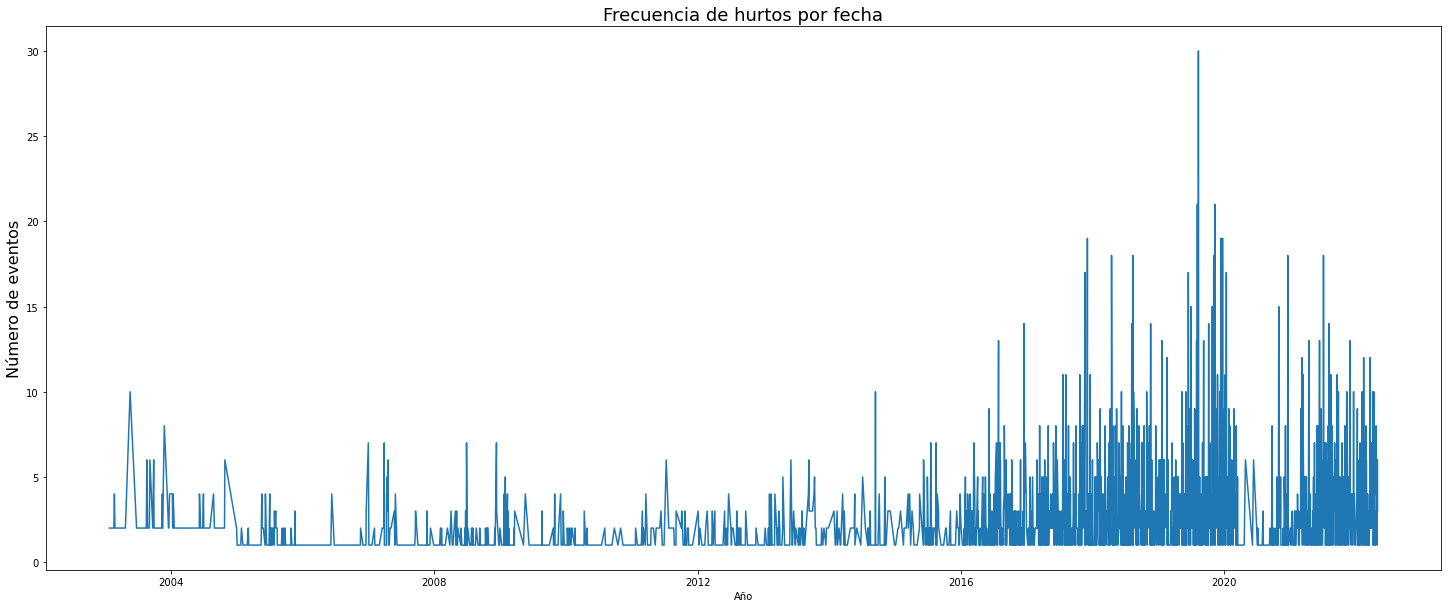

In [11]:
plt.figure(figsize=(25,10))
plt.plot(df_freq.index, df_freq['frecuencias'])
plt.xlabel('Año')
plt.ylabel('Número de eventos', fontsize=16)
plt.title('Frecuencia de hurtos por fecha', fontsize=18)
plt.show()

In [12]:
# Drop events until 2016
filt = df_freq[df_freq.index.year < 2016]
df_freq.drop(filt.index, inplace=True)

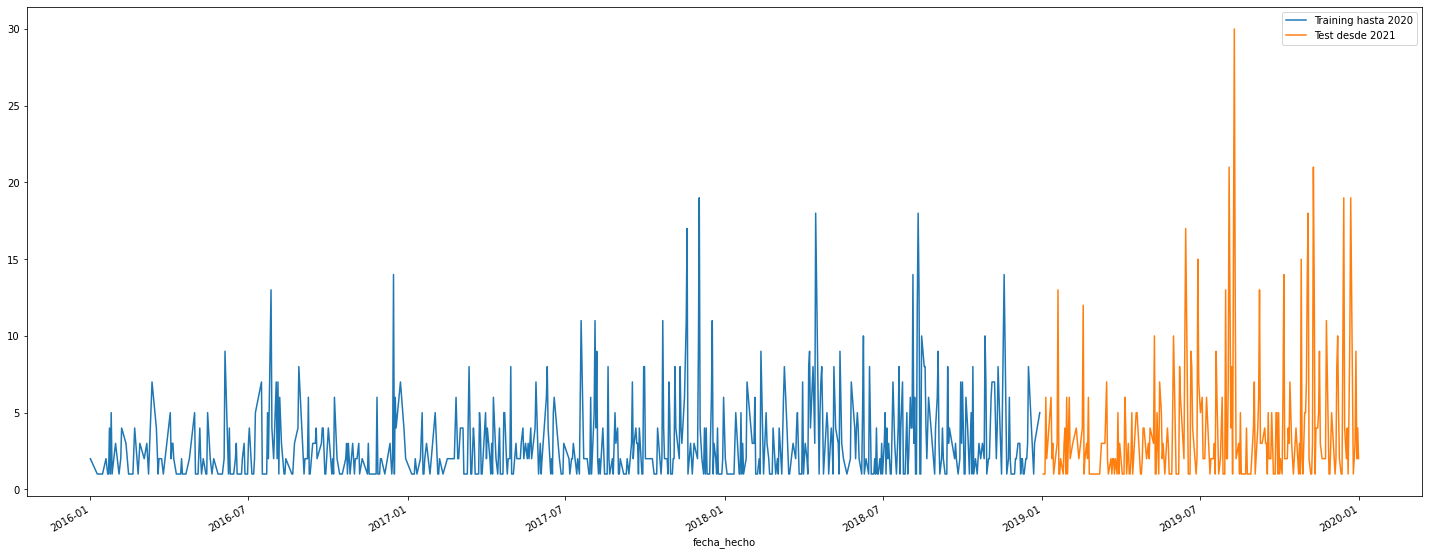

In [13]:
df_freq['frecuencias']['2016':'2018'].plot(figsize=(25,10), legend=True)
df_freq['frecuencias']['2019'].plot(figsize=(25,10), legend=True)
plt.legend(['Training hasta 2020', 'Test desde 2021'])
plt.show()

In [14]:
# Define training subset
df_train = df_freq[:'2018'].iloc[:,0].values
# Define testing subset
df_test = df_freq['2019'].iloc[:,0].values

C:\Users\kevin\AppData\Local\Temp/ipykernel_18356/2772919467.py:4: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  df_test = df_freq['2019'].iloc[:,0].values


In [15]:
# Make the sets a bidimensional matrix
df_train = df_train.reshape(-1,1)
df_test = df_test.reshape(-1,1)

# Define a scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scale the training data
df_train_scaled = scaler.fit_transform(df_train)

In [16]:
# Función para constuir un dataset x,y
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [17]:
look_back = 10
x_train, y_train = create_dataset(df_train, look_back)
print(x_train.shape)
print(y_train.shape)

(599, 10)
(599,)


In [18]:
keras.backend.clear_session()
# Arquitectura del modelo
model = Sequential()
model.add(LSTM(units = 50, input_shape=(x_train.shape[1],1)))
model.add(Dropout(0.1))
model.add(Dense(units=1))

In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 50)                10400     
                                                                 
 dropout (Dropout)           (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Compilación del modelo LSTM
model.compile(optimizer='adam', loss='mean_squared_error')
# Fitting to the training set
model.fit(x_train.reshape(x_train.shape[0], look_back,1), y_train, epochs = 400, batch_size = 32, verbose=1)

Epoch 1/400
19/19 [==============================] - 1s 5ms/step - loss: 13.5501
Epoch 2/400
19/19 [==============================] - 0s 4ms/step - loss: 7.7736
Epoch 3/400
19/19 [==============================] - 0s 4ms/step - loss: 7.5553
Epoch 4/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3505
Epoch 5/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3745
Epoch 6/400
19/19 [==============================] - 0s 4ms/step - loss: 7.4334
Epoch 7/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3479
Epoch 8/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3540
Epoch 9/400
19/19 [==============================] - 0s 4ms/step - loss: 7.4326
Epoch 10/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3538
Epoch 11/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3392
Epoch 12/400
19/19 [==============================] - 0s 4ms/step - loss: 7.3115
Epoch 13/400
19/19 [================

In [21]:
dataset_total = pd.concat((df_freq['frecuencias'][:'2018'], df_freq['frecuencias']['2019']), axis = 0)
inputs = dataset_total[len(dataset_total)-len(df_test) - look_back:].values
inputs = inputs.reshape(-1,1)
inputs  = scaler.transform(inputs)
inputs.shape

(255, 1)

In [22]:
# Preparación de X_test
x_test = []
for i in range(look_back,inputs.shape[0]):
    x_test.append(inputs[i-look_back:i,0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0],x_test.shape[1],1))

In [23]:
# Predicciones obtenidas
predicted_mugging = model.predict(x_test)
predicted_mugging = scaler.inverse_transform(predicted_mugging)

8/8 [==============================] - 0s 2ms/step


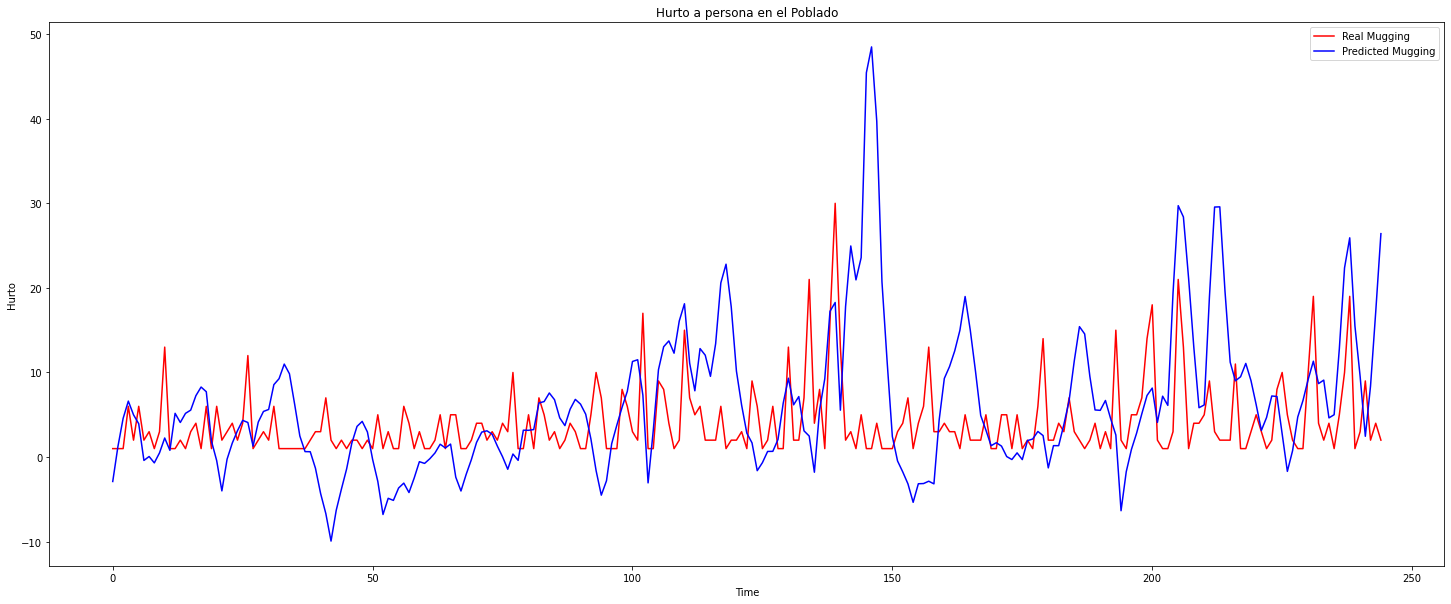

In [24]:
# Gráfico de resultados
plt.figure(figsize=(25,10))
plt.plot(df_test, color='red',label='Real Mugging')
plt.plot(predicted_mugging, color='blue',label='Predicted Mugging')
plt.title('Hurto a persona en el Poblado')
plt.xlabel('Time')
plt.ylabel('Hurto')
plt.legend()
plt.show()

In [25]:
# Evaluación del modelo mediante RMSE
rmse = math.sqrt(mean_squared_error(df_test, predicted_mugging))
print("El error de raíz cuadrática media es {}.".format(rmse))

El error de raíz cuadrática media es 9.142147575847947.
